In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras.applications.efficientnet as efficientnet

In [2]:
# Set a global random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
train_path = r'C:\Users\AI Server1\Desktop\Osteoarthritis_sehar\Osteo_dataset\train'
test_path = r'C:\Users\AI Server1\Desktop\Osteoarthritis_sehar\Osteo_dataset\test'
valid_path = r'C:\Users\AI Server1\Desktop\Osteoarthritis_sehar\Osteo_dataset\val'
# List of all five classes
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
# Create DataFrames for train, test, and validation sets
filepaths = []
labels = []
for d in [train_path, test_path, valid_path]:
    classlist = os.listdir(d)
    for klass in classlist:
        intklass = int(klass)  # Folder names are '0', '1', etc.
        label = list_of_classes[intklass]  # Map to class names
        classpath = os.path.join(d, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    pdf = pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf

# Print dataset sizes
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Print number of classes and image counts per class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is:', class_count)
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in classes:
    group = groups.get_group(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# Calculate average image dimensions
train_df_sample = train_df.sample(n=100, random_state=123)
ht, wt = 0, 0
for i in range(len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]
print('average height=', ht//100, ' average width=', wt//100, 'aspect ratio=', ht/wt)

train_df length: 5788  test_df length: 7444  valid_df length: 8270
The number of classes in the dataset is: 5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 767     
            Severe                  173     
average height= 224  average width= 224 aspect ratio= 1.0


In [4]:
drop_classes = ['Minimal', 'Doubtful']# dropping 1 , 2 class

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]  
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes 
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')  
for label in list_of_classes:
    group = groups.get_group(label) 
    print(label, len(group))

Healthy 2286
Moderate 767
Severe 173


In [5]:
# Function to trim DataFrame to a maximum number of samples per class
def trim(df, max_samples, min_samples, column):
    df = df.copy()
    trimmed_df = pd.DataFrame(columns=df.columns)
    groups = df.groupby(column)
    for label in df[column].unique():
        group = groups.get_group(label)
        count = len(group)
        if count > max_samples:
            sampled_group = group.sample(n=max_samples, random_state=123)
            trimmed_df = pd.concat([trimmed_df, sampled_group], axis=0)
        elif count >= min_samples:
            trimmed_df = pd.concat([trimmed_df, group], axis=0)
    print('after trimming, max samples per class:', max_samples, ' min samples:', min_samples)
    return trimmed_df

# Trim train_df to balance classes (max 1000 samples to retain more data)
max_samples = 1000  # Increased from 500 to retain more data
min_samples = 173   # Based on smallest class (Severe)
train_df = trim(train_df, max_samples, min_samples, 'labels')

after trimming, max samples per class: 1000  min samples: 173


In [6]:
# Function to balance DataFrame by augmenting underrepresented classes
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        os.mkdir(os.path.join(aug_dir, label))
    
    # Create augmented images
    total = 0
    gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=efficientnet.preprocess_input  # Add EfficientNet preprocessing
    )
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            print(f'Creating {delta} augmented images for class {label}')
            aug_gen = gen.flow_from_dataframe(
                group,
                x_col='filepaths',
                y_col=None,
                target_size=img_size,
                class_mode=None,
                batch_size=1,
                shuffle=False,
                save_to_dir=target_dir,
                save_prefix='aug-',
                color_mode='rgb',
                save_format='jpg'
            )
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total augmented images created=', total)
    
    # Create augmented DataFrame
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for klass in classlist:
        classpath = os.path.join(aug_dir, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now', len(df))
    return df

# Balance train_df to 1000 samples per class
n = 1000  # Target samples per class
working_dir = r'./'
img_size = (224, 224)
train_df = balance(train_df, n, working_dir, img_size)

Initial length of dataframe is 1940
Creating 233 augmented images for class Moderate
Found 767 validated image filenames.
Creating 827 augmented images for class Severe
Found 173 validated image filenames.
Total augmented images created= 1060
Length of augmented dataframe is now 3000


In [7]:
# Custom callback for learning rate adjustment
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1
    
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('ask_epoch = 0, setting to 1')
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs')
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print(f'Training until epoch {self.ask_epoch}, then you can halt or continue')
        self.start_time = time.time()
    
    def on_train_end(self, logs=None):
        print(f'Loading model with weights from epoch {self.best_epoch}')
        self.model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print(f'Training time: {hours} hours, {minutes:.1f} minutes, {seconds:.2f} seconds')
    
    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss {v_loss:.4f} is best, saving weights from epoch {epoch + 1}')
        else:
            print(f'\nValidation loss {v_loss:.4f} is above best {self.lowest_vloss:.4f}, keeping weights from epoch {self.best_epoch}')
        
        if self.ask and epoch + 1 == self.ask_epoch:
            print('\nEnter H to halt or an integer for more epochs')
            ans = input()
            if ans.lower() == 'h' or ans == '0':
                print(f'You entered {ans}, halting training at epoch {epoch + 1}')
                self.model.stop_training = True
            else:
                self.ask_epoch += int(ans)
                if self.ask_epoch > self.epochs:
                    print(f'Cannot train beyond {self.epochs} epochs')
                else:
                    print(f'Continuing to epoch {self.ask_epoch}')
                    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                    print(f'Current LR: {lr:.5f}, press Enter to keep or enter new LR')
                    ans = input()
                    if ans == '':
                        print(f'Keeping LR {lr:.5f}')
                    else:
                        new_lr = float(ans)
                        tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                        print(f'New LR: {new_lr:.5f}')

In [8]:
print (train_df['labels'].value_counts())

labels
Healthy     1000
Moderate    1000
Severe      1000
Name: count, dtype: int64


In [9]:
max_samples=500 
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, max samples per class: 500  min samples: 500


In [10]:
# Create data generators
batch_size = 32
train_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    preprocessing_function=efficientnet.preprocess_input
).flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)
valid_gen = ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input
).flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)
test_gen = ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input
).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1500 validated image filenames belonging to 3 classes.
Found 4600 validated image filenames belonging to 3 classes.
Found 4139 validated image filenames belonging to 3 classes.


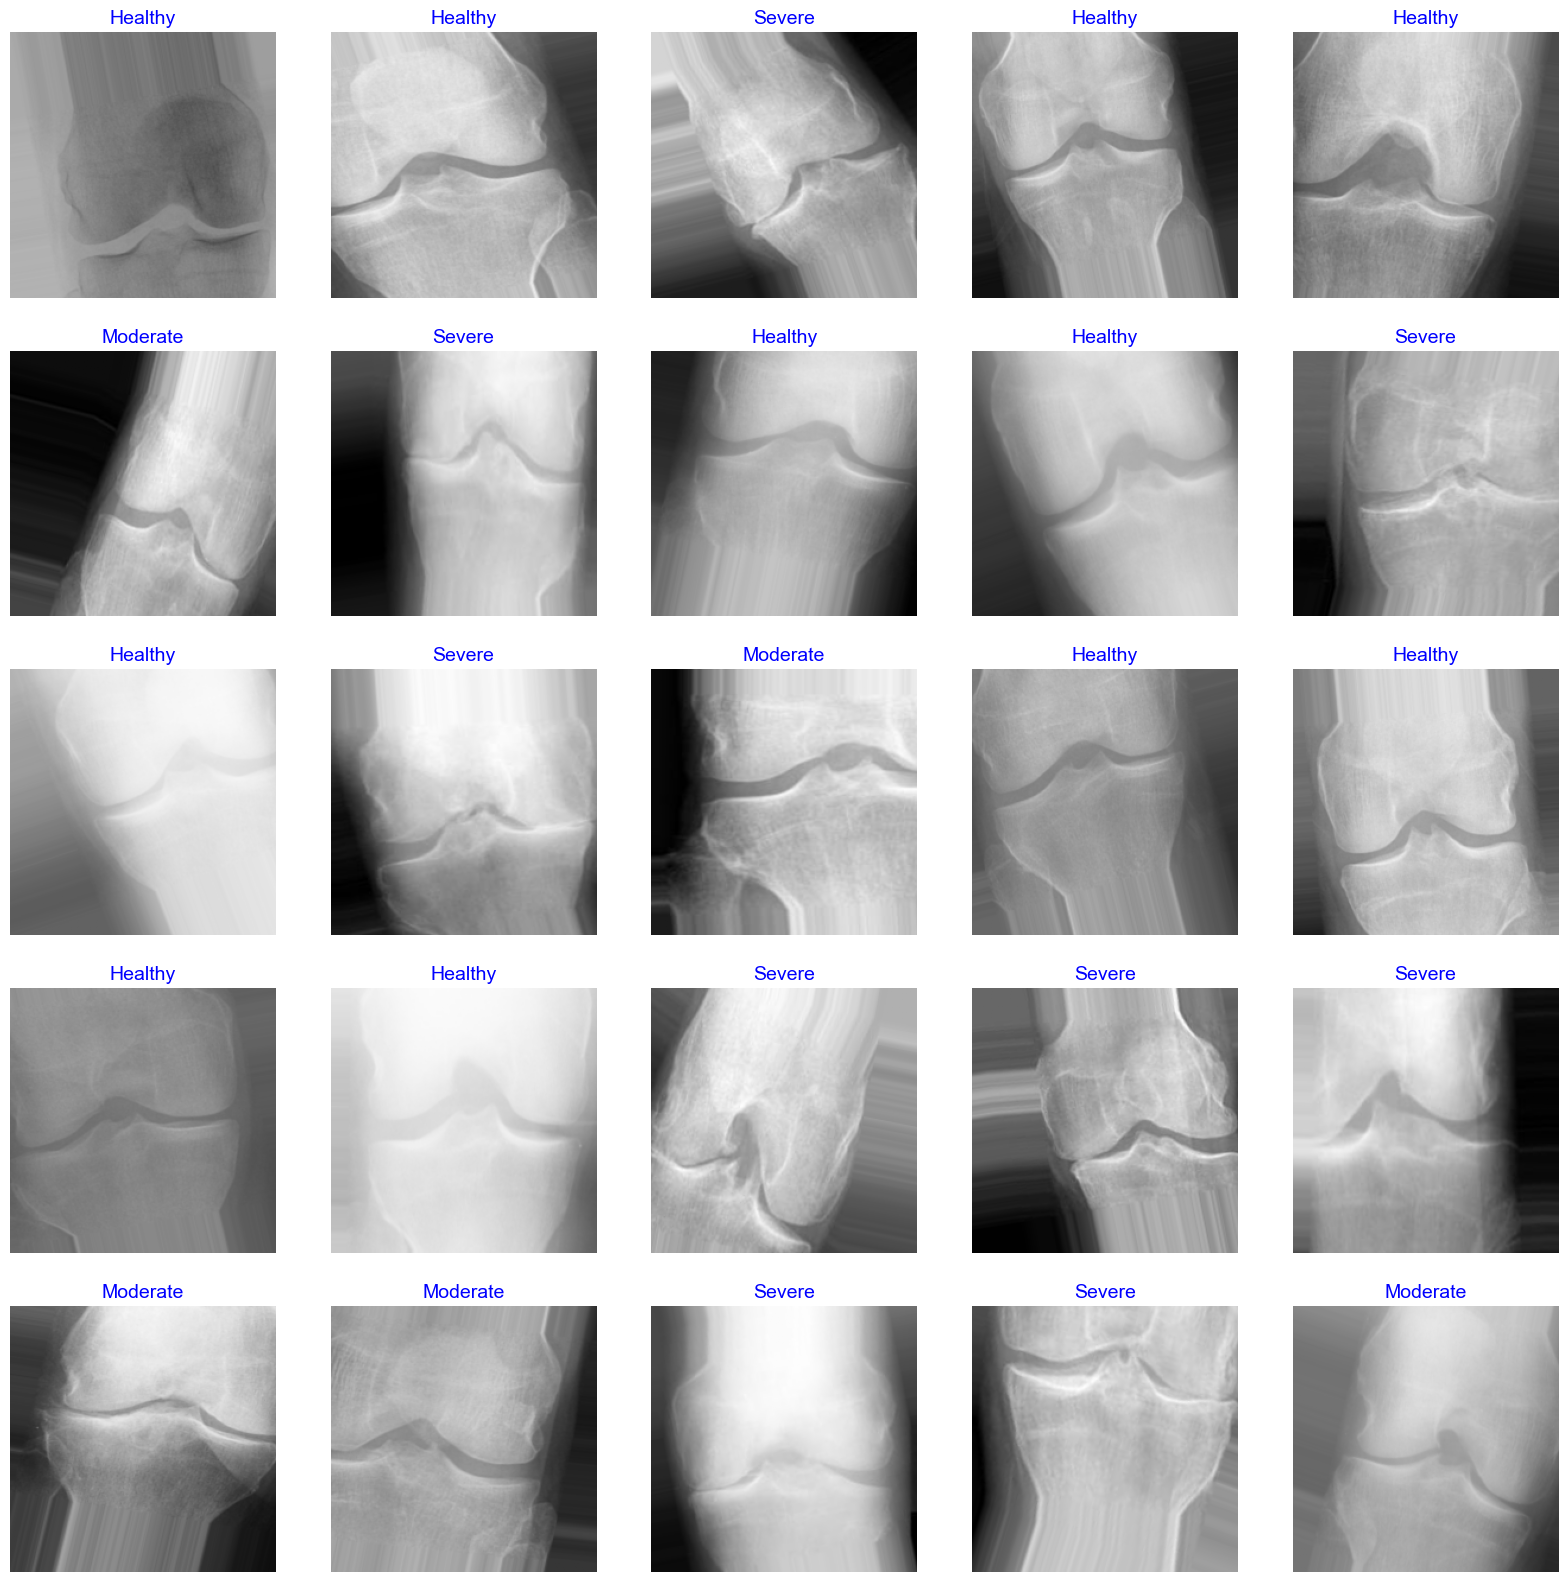

In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [12]:
# Build the model
base_model = efficientnet.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling=None)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
epochs = 40
ask_epoch = 5
callbacks = [LR_ASK(model, epochs, ask_epoch)]
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

Training until epoch 5, then you can halt or continue
Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 1.1600 - accuracy: 0.6213
Validation loss 0.5872 is best, saving weights from epoch 1
47/47 [==============================] - 355s 7s/step - loss: 1.1600 - accuracy: 0.6213 - val_loss: 0.5872 - val_accuracy: 0.7367
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.7407
Validation loss 0.3884 is best, saving weights from epoch 2
47/47 [==============================] - 338s 7s/step - loss: 0.7627 - accuracy: 0.7407 - val_loss: 0.3884 - val_accuracy: 0.8711
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.8040
Validation loss 0.2307 is best, saving weights from epoch 3
47/47 [==============================] - 341s 7s/step - loss: 0.4994 - accuracy: 0.8040 - val_loss: 0.2307 - val_accuracy: 0.9120
Epoch 4/40
47/47 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.8320


 10


Continuing to epoch 15
Current LR: 0.00100, press Enter to keep or enter new LR


Keeping LR 0.00100
47/47 [==============================] - 583s 13s/step - loss: 0.4022 - accuracy: 0.8440 - val_loss: 0.1883 - val_accuracy: 0.9283
Epoch 6/40
47/47 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9020
Validation loss 0.2061 is above best 0.1883, keeping weights from epoch 5
47/47 [==============================] - 335s 7s/step - loss: 0.2704 - accuracy: 0.9020 - val_loss: 0.2061 - val_accuracy: 0.9143
Epoch 7/40
47/47 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.9100
Validation loss 0.1432 is best, saving weights from epoch 7
47/47 [==============================] - 339s 7s/step - loss: 0.2487 - accuracy: 0.9100 - val_loss: 0.1432 - val_accuracy: 0.9454
Epoch 8/40
47/47 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9187
Validation loss 0.1550 is above best 0.1432, keeping weights from epoch 7
47/47 [==============================] - 340s 7s/step - loss: 0.2064 - accuracy: 0.9187 - val_loss: 

 10


Continuing to epoch 25
Current LR: 0.00100, press Enter to keep or enter new LR


Keeping LR 0.00100
47/47 [==============================] - 523s 11s/step - loss: 0.1585 - accuracy: 0.9447 - val_loss: 0.1519 - val_accuracy: 0.9443
Epoch 16/40
47/47 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9560
Validation loss 0.1826 is above best 0.1264, keeping weights from epoch 14
47/47 [==============================] - 337s 7s/step - loss: 0.1083 - accuracy: 0.9560 - val_loss: 0.1826 - val_accuracy: 0.9276
Epoch 17/40
47/47 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9600
Validation loss 0.1155 is best, saving weights from epoch 17
47/47 [==============================] - 336s 7s/step - loss: 0.1205 - accuracy: 0.9600 - val_loss: 0.1155 - val_accuracy: 0.9626
Epoch 18/40
47/47 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9660
Validation loss 0.1756 is above best 0.1155, keeping weights from epoch 17
47/47 [==============================] - 338s 7s/step - loss: 0.1002 - accuracy: 0.9660 - val_

 H


You entered H, halting training at epoch 25
47/47 [==============================] - 608s 13s/step - loss: 0.0827 - accuracy: 0.9760 - val_loss: 0.1711 - val_accuracy: 0.9613
Loading model with weights from epoch 17
Training time: 2.0 hours, 32.0 minutes, 39.35 seconds


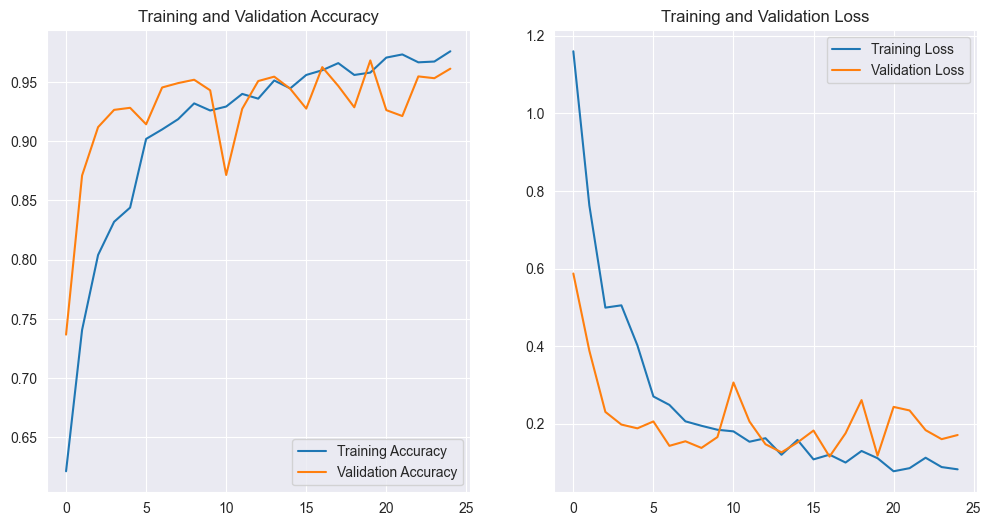

In [16]:
# Plot training and validation metrics
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('training_plot.png')
    plt.show()

plot_training(history)

In [20]:
import tensorflow as tf # Ensure this is at the top of your script/notebook if not already present

model_save_path = "./osteoarthritis_classification_model_saved_model" # Changed path to reflect SavedModel format
tf.saved_model.save(model, model_save_path)
print(f"Model saved to SavedModel format at {model_save_path}")

INFO:tensorflow:Assets written to: ./osteoarthritis_classification_model_saved_model\assets


INFO:tensorflow:Assets written to: ./osteoarthritis_classification_model_saved_model\assets


Model saved to SavedModel format at ./osteoarthritis_classification_model_saved_model


130/130 [==============================] - 198s 2s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.98      2925
    Moderate       0.94      0.91      0.93       990
      Severe       0.91      0.90      0.90       224

    accuracy                           0.97      4139
   macro avg       0.94      0.93      0.94      4139
weighted avg       0.96      0.97      0.96      4139



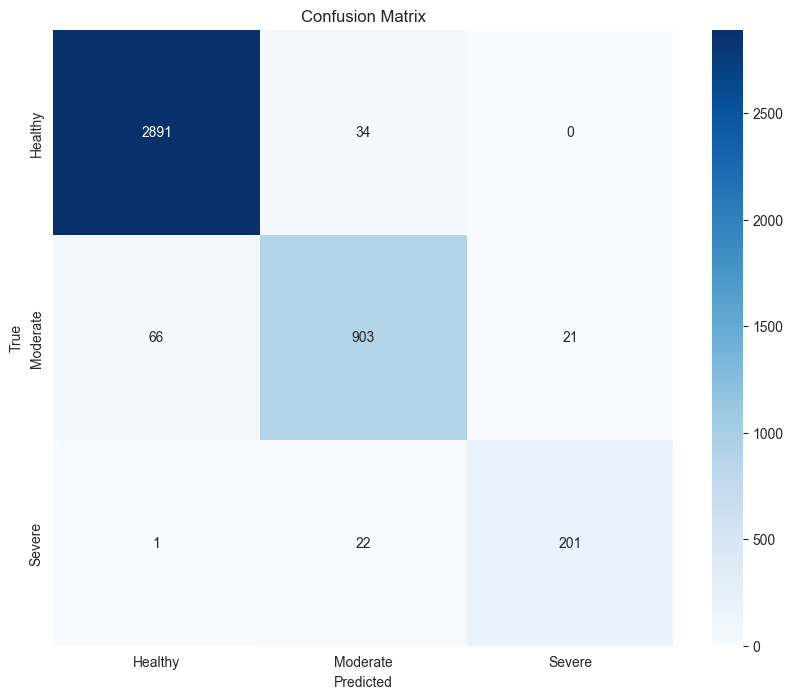

In [23]:
# Generate predictions on the test dataset
test_gen.reset()  # Reset the generator to ensure we start from the beginning
# Calculate the number of steps for prediction
test_steps = test_gen.n // test_gen.batch_size
if test_gen.n % test_gen.batch_size != 0:
    test_steps += 1
y_pred = model.predict(test_gen, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
test_gen.reset()  # Reset again
y_true = []
for i in range(test_steps):
    _, labels = next(test_gen)
    y_true.extend(np.argmax(labels, axis=1))
y_true = y_true[:len(y_pred_classes)]  # Match the length

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list_of_classes,
            yticklabels=list_of_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list_of_classes))